In [1]:
import math
import io
import torch
from torchvision import transforms
import numpy as np
import pickle
import re
import scipy.stats as st
import PIL
from collections import Counter
from PIL import Image
from PIL import ImageChops
import imageio
from pytorch_msssim import ssim, ms_ssim
import matplotlib.pyplot as plt
from statistics import mean
import compressai
import skimage
import torch.nn.functional as F
from compression import rates
from quality import psnr
from oligochecker import size
from oligoanalyzer import gc_stats
from oligoanalyzer import homopolymer_stats
from IQA_pytorch import SSIM, GMSD, LPIPSvgg, DISTS

In [2]:
from compressai.zoo import bmshj2018_factorized
from compressai.dna_entropy_coding.coder import Coder
from ipywidgets import interact, widgets

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
JPEG_SIZES = [
    '1192x832', 
    '853x945', 
    '945x840', 
    '2000x2496', 
    '560x888',
    '2048x1536', 
    '1600x1200', 
    '1430x1834', 
    '2048x1536', 
    '2592x1946'  
]

In [5]:
DATA_SET_LIST = [
    'kodak', 
    'jpeg_dna'
]

In [6]:
METRICS_LIST = [
    'PSNR', 
    'PSNR-YUV', 
    'PSNR-Y-CB-CR', 
    'MS-SSIM', 
    'IW-SSIM'
]

In [7]:
MODELS_LIST = [
    'benchmarkcodec', 
    'anchor1', 
    'anchor3', 
    'learningbased'
]

### Image extraction

In [8]:
def get_original_tensor(data_set, img_id): 
    path = get_original_image_path(data_set, img_id)
    img = Image.open(path).convert('RGB')
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    return img, x

In [9]:
def get_original_image_path(data_set, img_number): 
    img_path = 'assets/' + data_set
    if data_set == 'kodak':
        img_name = '/kodim{:02d}.png'.format(img_number)
        
    if data_set == 'jpeg_dna': 
        img_name = f"/{str(img_number).zfill(5)}_" + JPEG_SIZES[img_number-1]+'.png'
    return img_path + img_name

In [10]:
def get_decoded_image_path(data_set, model_name, img_number, quality): 
    path = 'assets/' + data_set +'/' + model_name
    img_name = ''
    if data_set == 'kodak': 
        img_name = '/{}kodim{:02d}.png'.format(quality, img_number)
        
    elif data_set == 'jpeg_dna':
        img_name = f"/JPEG-1_{str(img_number).zfill(5)}" + '_' + JPEG_SIZES[img_number-1] + '_' + str(quality) + '_decoded' + '.jpg'
    else : 
        return ''
    return path + img_name

In [11]:
def get_decoded_tensor(data_set, model_name, img_number, quality):
    path = get_decoded_image_path(data_set, model_name, img_number, quality)
    img = Image.open(path).convert('RGB')   
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    return img, x

In [12]:
def get_dna_path(data_set, model_name, img_number, quality): 
    path = 'assets/' + data_set +'/' + model_name
    dna_name = ''
    if data_set == 'kodak': 
        dna_name = '/{}kodim{:02d}.fasta'.format(quality, img_number)
        
    elif data_set == 'jpeg_dna':
        dna_name = f"/JPEG-1_{str(img_number).zfill(5)}" + '_' + JPEG_SIZES[img_number-1] + '_' + str(quality) + '.fasta'
    else : 
        return ''
    return path + dna_name

In [13]:
def get_dna(data_set, model_name, img_number, quality):
    path = get_dna_path(data_set, model_name, img_number, quality)
    fasta_file = open(path)
    dna = fasta_file.read()
    fasta_file.close()
    return dna


# Biochemical constraints

### DNA CG contents

In [14]:
def CG_content(dna) : 
    return 100*(dna.count("C")+dna.count("G"))/len(dna)

In [15]:
def cg_contents(model_name, data_set = 'jpeg_dna'): 
    """
    Plots of the percentage of CG nucleotides in dna strands in regards of the quality of the 
    encoding, computed for the 24 images of the kodak data set.  
    
    Parameters
    ----------
    model_name: string 
        name of the model to be used for dna encoding
        'anchor1', 'anchor3', 'benchmark codec' or 'learning based'
        
    Returns
    -------
    A plot saved in the folder plots/
    """
    if data_set == 'kodak': 
        number_of_images = 24
    elif data_set == 'jpeg_dna': 
        number_of_images = 10
    else : 
        print("Ivalid data set name, please enter  'jpeg_dna' or 'kodak'.")
        return
    
    
    for i in range(1, number_of_images): 
        cg = []
        bit_rate = []
        print('image' + str(i))
        for q in range(1,8):
            print ('quality' + str(q))
            dna = get_dna(data_set, model_name, i, q)
            img, x = get_decoded_tensor(data_set, model_name, i, q)
            cg.append(CG_content(dna))
            bit_rate.append(compute_bit_rate(img, dna))
            
        plt.plot(bit_rate, cg)
        
    plt.xlabel('Rate (nt/pxl)')
    plt.ylabel('CG content (%)')
    plt.title('CG contents of ' + model_name +' dna for the ' + data_set + ' data set')
    plt.ylim(0, 100) 
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('plots/cg_' + data_set + '_'+ model_name + '.jpeg', bbox_inches='tight')
    plt.show()
    


#cg_contents('anchor1')
#cg_contents('anchor3')
#cg_contents('benchmarkcodec')
#cg_contents('learningbased')


### Oligo length

In [16]:
def display_oligo_length(dna): 
    stats = size.compute_data(dna)
    print(type(stats))
    size.nice_print(stats)
dna = get_dna('kodak', 'anchor1', 2, 1)
display_oligo_length(dna)


<class 'dict'>
96950 oligos have a length of 1


### Homopolymers

In [22]:
def homopolymer_data(dna):
    (hom, nuc_hom, avg_hom, hom_pos_b) = homopolymer_stats.compute_data(dna)
    return (hom, nuc_hom, avg_hom, hom_pos_b)

def count_model_homopolymers(data_set, model_name): 
    if data_set == 'kodak': 
        number_of_images = 24
    elif data_set == 'jpeg_dna': 
        number_of_images = 10
    else : 
        print('Incorrect data set argument.')
        return
    homopolymers = 0
    for img_id in range(1,number_of_images): 
        for q in range(1,8): 
            dna = get_dna(data_set, model_name, img_id, q)
            (hom, nuc_hom, avg_hom, hom_pos_b) = homopolymer_data(dna)
            homopolymers += sum(hom)
    print('Number of homopolymers in all the DNA generated by the ' + model_name 
          + ' model on the ' + data_set + ' data set = ' + str(homopolymers))
    return homopolymers

def count_all_homopolymers(): 
    for data_set in DATA_SET_LIST: 
        for model_name in MODELS_LIST: 
            count_model_homopolymers(data_set, model_name)
            
count_all_homopolymers()

Number of homopolymers in all the DNA generated by the benchmarkcodec on the kodak data set = 0
Number of homopolymers in all the DNA generated by the anchor1 on the kodak data set = 0
Number of homopolymers in all the DNA generated by the anchor3 on the kodak data set = 0
Number of homopolymers in all the DNA generated by the learningbased on the kodak data set = 0
Number of homopolymers in all the DNA generated by the benchmarkcodec on the jpeg_dna data set = 0
Number of homopolymers in all the DNA generated by the anchor1 on the jpeg_dna data set = 0
Number of homopolymers in all the DNA generated by the anchor3 on the jpeg_dna data set = 0
Number of homopolymers in all the DNA generated by the learningbased on the jpeg_dna data set = 0


In [13]:
'''
def count_homopolymers(count, homopolymers, dna, i):
    if i == 0 :
        return count 
    elif dna[i] == dna[i-1] : 
        count_homopolymers(count, homo+1, dna, i-1)
    elif homo >= 3 : 
        count.append(homo)
        count_homopolymers(count, 0, dna, i-1)
    else : 
        count_homopolymers(count, 0, dna, i-1) 
        
def check_homopolymers(dna) :
    count = 0
    for i in range(len(dna)-2): 
        if ((dna[i] == dna[i+1]) & (dna[i+1] == dna[i+2])): 
            ++ count  
    if count > 0: 
        print (count_homopolymers(0, [], dna, len(dna)))
    return count 
'''

In [14]:
'''
def all_homopolymers(data_set = 'jpeg_dna'): 
    anchor1_count = 0
    anchor3_count = 0
    learningbased_count = 0
    benchmarkcodec_count = 0
    if data_set == 'kodak': 
        number_of_images = 24
    elif data_set == 'jpeg_dna': 
        number_of_images = 10
    else : 
        print("Ivalid data set name, please enter  'jpeg_dna' or 'kodak'.")
        return
    for q in range(1, 9): 
        for i in range(1, number_of_images + 1): 
            anchor1_dna = get_dna('anchor1', data_set,i,q)
            anchor3_dna = get_dna('anchor3', data_set,i,q)
            benchmarkcodec_dna = get_dna('benchmarkcodec', data_set,i,q)
            learningbased_dna = get_dna('learningbased', data_set,i,q)
            
            anchor1_count += check_homopolymers(anchor1_dna) 
            anchor3_count += check_homopolymers(anchor3_dna)
            learningbased_count += check_homopolymers(learningbased_dna)
            benchmarkcodec_count += check_homopolymers(benchmarkcodec_dna)

    print("Number of homopolymers in anchor 1 dna : " + str(anchor1_count))
    print("Number of homopolymers in anchor 3 dna : " + str(anchor3_count))
    print("Number of homopolymers in learning based dna : "+ str(learningbased_count))
    print("Number of homopolymers in benchmark codec dna : "+ str(learningbased_count))
'''    
    

In [15]:
#all_homopolymers()

# Objective quality evaluation

### Metrics

In [16]:
def add_padding(a, b):
    # Pad the smaller tensor with zeros to match the size of the larger tensor
    height_diff = abs(b.shape[2] - a.shape[2])
    width_diff = abs(b.shape[3] - a.shape[3])

    padding = (width_diff // 2, width_diff - width_diff // 2,
               height_diff // 2, height_diff - height_diff // 2)
    # Find the smaller tensor
    if a.shape[2] < b.shape[2] or a.shape[3] < b.shape[3]:
        a = F.pad(a, padding)
    else:
        b = F.pad(b, padding)
    return a, b

#### PSNR


- PSNR = Peak Signal-to-Noise Ratio
- Measures the difference between an original image and a compressed or reconstructed version of it. 
- The higher the PSNR value, the better the quality of the compressed or reconstructed image.

\begin{equation}
PSNR = - 10 \cdot \log_{10} (MSE)
\end{equation}




In [17]:
def compute_psnr(a, b):
    
    if a.shape != b.shape:
        a, b = add_padding(a, b)
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)


In [18]:
def compute_psnr_yuv(a, b):
    return psnr.psnr_yuv(a, b)

In [19]:
def compute_psnr_y_cb_cr(a, b): 
    return psnr.psnr_y_cb_cr(a, b)

#### MS-SSIM
- MS-SSIM = Multi-Scale Structural Similarity Index
- Measures the similarity between two images
- Takes into account multiple scales of image structures
- The higher the MS-SSIM, the higher the similqrity between 2 images

In [20]:
def compute_msssim(a, b):
    if a.shape != b.shape:
        a, b = add_padding(a,b)
    return ms_ssim(a, b, data_range=1.).item()

#### IW-SSIM
- IW-SSIM = Information-Weighted Structural Similarity Index
- Takes into account the importance of different regions in the image, and assigns them different weights based on their visual significance
- The higher the MS-SSIM, the higher the similqrity between 2 images

\begin{equation}
\text{IW-SSIM} = \frac{(2 \mu_a \mu_b + c_1)(2\sigma_{ab} + c_2)}{(\mu_a^2 + \mu_b^2 + c_1)(\sigma_a^2 + \sigma_b^2 + c_2)} \cdot \text{SSIM}
\end{equation}


In [21]:
def compute_iwssim(a, b, k=0.01):
    if a.shape != b.shape:
        a, b = add_padding(a, b)
    # Compute the constants c1 and c2 used in the IW-SSIM formula
    c1 = (k * 1) ** 2
    c2 = (k * 1) ** 2
    # Compute the mean, variance, and covariance of the two input images
    mean_a = a.mean(dim=(1, 2, 3), keepdim=True)
    mean_b = b.mean(dim=(1, 2, 3), keepdim=True)
    var_a = ((a - mean_a) ** 2).mean(dim=(1, 2, 3), keepdim=True)
    var_b = ((b - mean_b) ** 2).mean(dim=(1, 2, 3), keepdim=True)
    cov_ab = ((a - mean_a) * (b - mean_b)).mean(dim=(1, 2, 3), keepdim=True)
    
    # Compute the SSIM value between the two input images using pytorch_msssim's ssim function
    ssim_val = ssim(a, b, data_range=1.0, win_size=11, size_average=True)
    
    # Compute the IW-SSIM value using the mean, variance, covariance, and SSIM values
    iwssim_val = ((2 * mean_a * mean_b + c1) * (2 * cov_ab + c2)) / ((mean_a ** 2 + mean_b ** 2 + c1) * (var_a + var_b + c2)) * ssim_val
    
    # Return the average IW-SSIM value across the batch
    return iwssim_val.mean().item()


In [22]:
def compute_bit_rate(img, dna): 
    h, w = img.size
    return len(dna)/(h*w)

### Plots

In [57]:
def compute_metric(metric_name, original_tensor, reconstructed_tensor): 
    
    """
    Computes the quality metric given by 'metric_name' for an encoded image, 
    in comparison to an original image. 

    Parameters
    ----------
    metric_name: string 
        name of the metric to be computed.
        'PSNR', 'PSNR-HVS-M' 'MS-SSIM', or 'IW-SSIM.
    original_tensor: tensor
        original image run through the different encoder
    reconstructed_tensor: tensor
        reconstructed image tensor
        

    Returns
    -------
    The computed value of the given quality metric for the specified image
    """
    
    if metric_name == 'PSNR' : 
        return compute_psnr(original_tensor, reconstructed_tensor)
    
    elif metric_name == 'PSNR-YUV':
        original_image = transforms.ToPILImage()(original_tensor.squeeze().cpu())
        original_image = np.array(original_image)
        reconstructed_image = transforms.ToPILImage()(reconstructed_tensor.squeeze().cpu())
        reconstructed_image = np.array(reconstructed_image)
        return compute_psnr_yuv(original_image, reconstructed_image)
    
    elif metric_name == 'PSNR-Y-CB-CR':
        original_image = transforms.ToPILImage()(original_tensor.squeeze().cpu())
        original_image = np.array(original_image)
        reconstructed_image = transforms.ToPILImage()(reconstructed_tensor.squeeze().cpu())
        reconstructed_image = np.array(reconstructed_image)
        compute_psnr_y_cb_cr(original_image, reconstructed_image)
        
    elif metric_name == 'MS-SSIM': 
        return compute_msssim(original_tensor, reconstructed_tensor)
    
    elif metric_name =='IW-SSIM': 
        return compute_iwssim(original_tensor, reconstructed_tensor)
    else:
        print("Invalid argument : " + metric_name + ".")
        return

In [45]:
def plot_metric(metric_name, img_number, data_set = 'jpeg_dna'): 
    """
    Plots a quality metric given by metric_name, for a an image encoded by different models.
    
    Parameters
    ----------
    metric_name: string 
        name of the metric to be plotted
        'PSNR', 'PSNR-YUV', 'PSNR-Y-CB-CR' 'MSSSIM', or 'IWSSIM'
    data_set : string
        name of the data set on which to perform the computations
        'jpeg_dna' or 'kodak'
    img_number: 
        number of the image of interest in the given data set

    Returns
    -------
    A plot saved in the folder /plots
    """
    
    # Check if the metric argument is valid
    if (metric_name in METRICS_LIST) & (data_set in DATA_SET_LIST) :
        
        if data_set == 'kodak' : 
            number_of_images = 24
        elif data_set == 'jpeg_dna' : 
            number_of_images = 10
        if (img_number > number_of_images) or (img_number<1): 
            print('Invalid image number')
    # Initialize empty lists to store metrics and bit rates for the image at all quality levels
        learning_based_metric = []
        anchor1_metric = [] 
        anchor3_metric = []
        benchmark_codec_metric = []
        learning_based_bitrates = []
        anchor1_bitrates = []
        anchor3_bitrates = []
        benchmark_codec_bitrates = []
        img, x = get_original_tensor(data_set, img_number)

       # Loop through quality levels 1-8
        for quality in range(1, 9):

            # Load image, tensor and dna for the learning-based method and calculate bit rate
            learning_based_img, learning_based_tensor = get_decoded_tensor(data_set, 'learningbased', img_number,quality)
            learning_based_dna = get_dna( data_set, 'learningbased', img_number,quality)
            learning_based_bitrates.append(compute_bit_rate(learning_based_img, learning_based_dna))

            # Load image, tensor and dna for anchor1, calculate bit rate
            anchor1_img, anchor1_tensor = get_decoded_tensor(data_set, 'anchor1', img_number, quality)
            anchor1_dna = get_dna(data_set, 'anchor1', img_number,quality)
            anchor1_bitrates.append(compute_bit_rate(anchor1_img, anchor1_dna))

            # Load image, tensor and dna for anchor3, calculate bit rate
            anchor3_img, anchor3_tensor = get_decoded_tensor(data_set, 'anchor3', img_number, quality)
            anchor3_dna = get_dna(data_set, 'anchor3', img_number,quality)
            anchor3_bitrates.append(compute_bit_rate(anchor3_img, anchor3_dna))

            # Load image, tensor and dna for the JPEG DNA benchmark codec, calculate bit rate
            benchmark_codec_img, benchmark_codec_tensor = get_decoded_tensor(data_set, 'benchmarkcodec', img_number, quality)
            benchmark_codec_dna = get_dna( data_set, 'benchmarkcodec',img_number,quality)
            benchmark_codec_bitrates.append(compute_bit_rate(benchmark_codec_img, benchmark_codec_dna))

            # Calculate metric for each model and add to corresponding list 

            learning_based_metric.append(compute_metric(metric_name, x, learning_based_tensor))
            anchor1_metric.append(compute_metric(metric_name, x, anchor1_tensor))
            anchor3_metric.append(compute_metric(metric_name, x, anchor3_tensor))
            benchmark_codec_metric.append(compute_metric(metric_name, x, benchmark_codec_tensor))


        # plot results
        if 'PSNR' in metric_name: : 
            unit = ' (dB)'
        else : unit = ''
        plt.plot(learning_based_bitrates, learning_based_metric, label='Learning based', marker='o', markersize=3)
        plt.plot(anchor1_bitrates, anchor1_metric, label='Anchor 1', marker='o', markersize=3)
        plt.plot(anchor3_bitrates, anchor3_metric, label='Anchor 3', marker='o', markersize=3)
        plt.plot(benchmark_codec_bitrates, benchmark_codec_metric, label='JPEG DNA Benchmark Codec', marker='o', markersize=3)
        plt.xlabel('Rate (nts/pxl)')
        plt.ylabel(metric_name + unit)
        plt.title(metric_name +' of the image ' + str(img_number)+ ' of the ' + data_set +  ' set for different models')
        plt.legend()
        plt.savefig('plots/'+ data_set + '_' + metric_name +'im' + str(img_number) +'.jpeg')
        plt.show()
        
    else : 
        print('Invalid data set name or metric name')
        return

In [42]:
def plot_all_metrics(img_number, data_set = 'jpeg_dna'): 
        for metric in METRICS_LIST: 
            plot_metric(metric, img_number, data_set)
        
def plot_all(data_set = 'jpeg_dna'): 
    if data_set == 'jpeg_dna': 
        number_of_images = 10
    elif data_set == 'kodak': 
        number_of_images = 24   
    for img_id in range(1,number_of_images+1):
        plot_all_metrics(img_id, data_set)

#plot_all()

In [47]:
def plot_avg_metric(metric_name, data_set = 'jpeg_dna'): 
    """
    Plots the average across all the images of the kodak data set of the quality metric 
    given by metric_name. The images are encoded by different models. 
    
    Parameters
    ----------
    metric_name: string 
        name of the metric to be plotted
        'PSNR', 'MSSSIM', or 'IWSSIM'
    data_set : string
        name of the data set on which to perform the computations
        'jpeg_dna' or 'kodak'
    Returns
    -------
    A plot saved in the folder /plots
    """
    
    # Check input
    if (metric_name in METRICS_LIST) & (data_set in DATA_SET_LIST): 
        
        if data_set == 'kodak': 
            number_of_images = 24
        elif data_set == 'jpeg_dna': 
            number_of_images = 10
    
        # Initialize empty lists to store average metrics and bit rates for each anchor type
        learning_based_avg_metrics = []
        anchor1_avg_metrics = []
        anchor3_avg_metrics = []
        benchmark_codec_avg_metrics = []

        learning_based_avg_bitrates = []
        anchor1_avg_bitrates = []
        anchor3_avg_bitrates = []
        benchmark_codec_avg_bitrates = []

        # Loop through quality levels 1-8
        for quality in range(1, 9):
            # Initialize empty lists to store metrics and bit rates for all images at the current quality level
            learning_based_metric = []
            anchor1_metric = [] 
            anchor3_metric = []
            benchmark_codec_metric = []

            learning_based_bitrates = []
            anchor1_bitrates = []
            anchor3_bitrates = []
            benchmark_codec_bitrates = []
            # Loop through images 1-24 (kodak data set)
            for img_id in range(1, number_of_images+1):
                img, x = get_original_tensor(data_set,img_id)

                # Load image, tensor and dna for the learning-based method and calculate bit rate
                learning_based_img, learning_based_tensor = get_decoded_tensor(data_set, 'learningbased', img_id, quality)
                learning_based_dna = get_dna(data_set, 'learningbased', img_id, quality)
                learning_based_bitrates.append(compute_bit_rate(learning_based_img, learning_based_dna))

                # Load image, tensor and dna for anchor1, calculate bit rate
                anchor1_img, anchor1_tensor = get_decoded_tensor(data_set, 'anchor1', img_id, quality)
                anchor1_dna = get_dna(data_set, 'anchor1', img_id, quality)
                anchor1_bitrates.append(compute_bit_rate(anchor1_img, anchor1_dna))

                # Load image, tensor and dna for anchor3, calculate bit rate
                anchor3_img, anchor3_tensor = get_decoded_tensor(data_set, 'anchor3', img_id, quality)
                anchor3_dna = get_dna(data_set, 'anchor3', img_id, quality)
                anchor3_bitrates.append(compute_bit_rate(anchor3_img, anchor3_dna))

                # Load image, tensor and dna for the JPEG DNA benchmark codec, calculate bit rate
                benchmark_codec_img, benchmark_codec_tensor = get_decoded_tensor(data_set, 'benchmarkcodec', img_id, quality)
                benchmark_codec_dna = get_dna(data_set, 'benchmarkcodec', img_id, quality)
                benchmark_codec_bitrates.append(compute_bit_rate(benchmark_codec_img, benchmark_codec_dna))

                # Calculate metric for each model and add to corresponding list
                learning_based_metric.append(compute_metric(metric_name, x, learning_based_tensor))
                anchor1_metric.append(compute_metric(metric_name, x, anchor1_tensor))
                anchor3_metric.append(compute_metric(metric_name, x, anchor3_tensor))
                benchmark_codec_metric.append(compute_metric(metric_name, x, benchmark_codec_tensor))

            # Calculate the average bit rate and metric, and add them to the corresponding lists 
            learning_based_avg_bitrates.append(mean(learning_based_bitrates))
            learning_based_avg_metrics.append(mean(learning_based_metric))
            anchor1_avg_bitrates.append(mean(anchor1_bitrates))
            anchor1_avg_metrics.append(mean(anchor1_metric))
            anchor3_avg_bitrates.append(mean(anchor3_bitrates))
            anchor3_avg_metrics.append(mean(anchor3_metric))
            benchmark_codec_avg_bitrates.append(mean(benchmark_codec_bitrates))
            benchmark_codec_avg_metrics.append(mean(benchmark_codec_metric))

        # Plot the result
        unit = ''
        if 'PSNR' in metric_name: 
            unit = (' (dB)')
        plt.plot(learning_based_avg_bitrates, learning_based_avg_metrics, label='Learning based', marker='o', markersize=3)
        plt.plot(anchor1_avg_bitrates, anchor1_avg_metrics, label='Anchor 1', marker='o', markersize=3)
        plt.plot(anchor3_avg_bitrates, anchor3_avg_metrics, la bel='Anchor 3', marker='o', markersize=3)
        plt.plot(benchmark_codec_avg_bitrates, benchmark_codec_avg_metrics, label='JPEG DNA Benchmark Codec', marker='o', markersize=3)
        plt.xlabel('Rate (nts/pxl)')
        plt.ylabel(metric_name + unit)
        plt.title('Average ' + metric_name +' across the ' + data_set + ' data set for different models')
        plt.legend()
        plt.savefig('plots/avg_'+ data_set + '_' + metric_name +'.jpeg')
        plt.show()
    else : 
        print ('Invalid metric name or data set. ')
        return
    

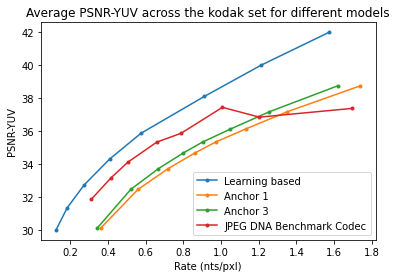

In [50]:
plot_avg_metric('PSNR-YUV', 'kodak')

In [49]:
def plot_all_average_metrics(data_set='jpeg_dna'):
    """
    Plots the average PSNR, MSSSIM, and IW-SSIM across all the images of the kodak data set 
    at different quality levels.
    The images are encoded by different models. 
    """
    for metric in METRICS_LIST : 
        plot_avg_metric(metric, data_set)
    

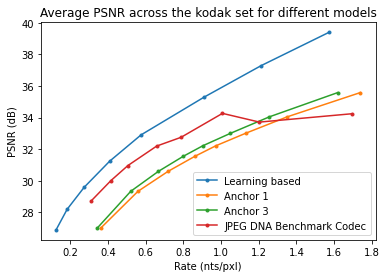

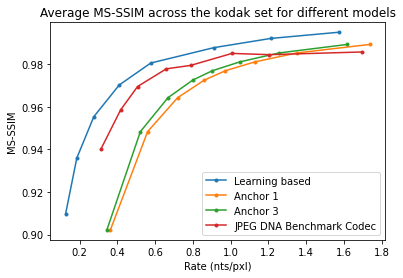

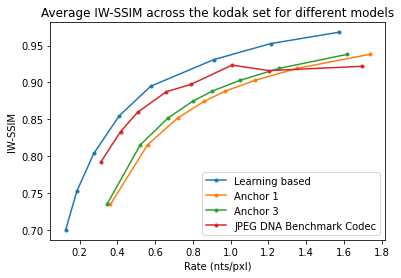

In [126]:
plot_all_average_metrics('kodak')

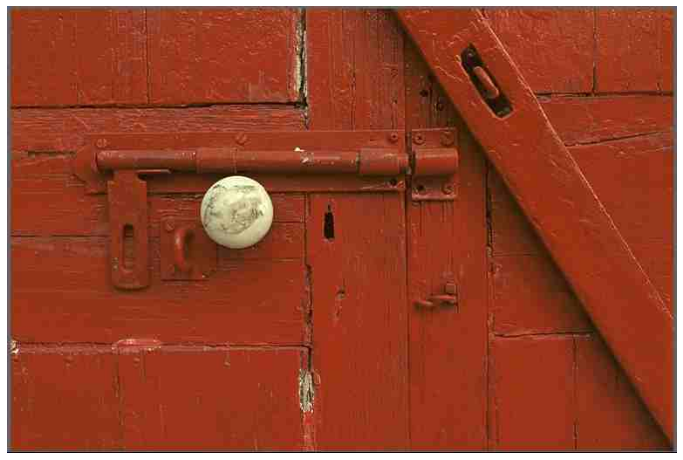

In [170]:
img6, x6 = get_decoded_tensor('kodak', 'anchor3', 2, 2)
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.imshow(img6)
plt.show()
    